In [28]:
import pandas as pd
import numpy as np
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
PATH = "data/"

In [3]:
train = pd.read_csv(PATH + "train.csv")
test = pd.read_csv(PATH + "test.csv")

In [4]:
train.head()

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,0000997932d777bf,Explanation\nWhy the edits made under my usern...,0,0,0,0,0,0
1,000103f0d9cfb60f,D'aww! He matches this background colour I'm s...,0,0,0,0,0,0
2,000113f07ec002fd,"Hey man, I'm really not trying to edit war. It...",0,0,0,0,0,0
3,0001b41b1c6bb37e,"""\nMore\nI can't make any real suggestions on ...",0,0,0,0,0,0
4,0001d958c54c6e35,"You, sir, are my hero. Any chance you remember...",0,0,0,0,0,0


In [5]:
train.isna().sum()

id               0
comment_text     0
toxic            0
severe_toxic     0
obscene          0
threat           0
insult           0
identity_hate    0
dtype: int64

In [6]:
test.isna().sum()

id              0
comment_text    0
dtype: int64

In [7]:
list_categories = ['toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate']

In [8]:
train_x = train['comment_text']
train_y = train[list_categories]

In [9]:
no_of_features = 20000

In [10]:
tokenizer = Tokenizer(num_words=no_of_features)

In [11]:
tokenizer.fit_on_texts(texts=train_x)

In [12]:
tokenized_train_x = tokenizer.texts_to_sequences(train_x)
tokenized_train_y = tokenizer.texts_to_sequences(test)

In [13]:
sequence_lengths = [len(sequence) for sequence in tokenized_train_x]

In [14]:
max(sequence_lengths)

1400

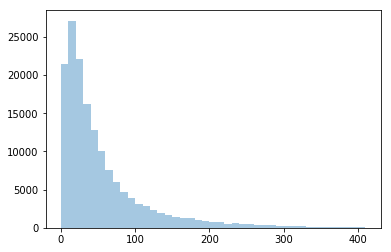

In [35]:
sns.distplot(sequence_lengths, kde=False, bins=np.arange(0, 420, 10))

In [27]:
max_length = 200

In [32]:
padded_train_x = pad_sequences(tokenized_train_x, maxlen=max_length)

In [33]:
padded_train_x.shape

(159571, 200)